# Using Runner method of the model

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pymongo
import osmnx as ox
import matplotlib.pyplot as plt
from shapely import geometry
from descartes import PolygonPatch
import pickle

from backend.models.time_distance_model import TimeDistanceModel
from backend.models import handle_points
from backend.models import isoline
from backend.models.geocode import Geocoder
from backend.models.fetch_zips import fetch_zip_boundary_polygons

import warnings
warnings.filterwarnings('ignore')

client = pymongo.MongoClient('mongo', 27017)
na_db = client['na-db']

Let's start by picking a zip code. This is a rural area south of lake tahoe, not too far from Folsom.

In [3]:
zip_code = '95666'
county_name='Amador'

I am going to fetch the zip boundary from USPS API [here](https://gis.usps.com/arcgis/rest/services/EDDM/EDDM_ZIP5/MapServer/1).

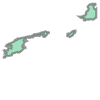

In [4]:
fetched_obj = fetch_zip_boundary_polygons([zip_code])
zip_geometry = fetched_obj['features'][0]['geometry']
zip_polygon = geometry.shape(zip_geometry)
zip_polygon

This zip code has an unusual shape.

In [5]:
csv_path = '../../data/all_pcps_addresses.csv'
providers = handle_points.fetch_provider_addresses(csv_path)
close_providers = providers[providers.County.isin(['Amador', 'Sacramento', 'El Dorado', 'Calaveras', 'San Joaquin', 'Alpine'])]
print('After filtering for close providers, there are {} rows in the df.'.format(close_providers.shape[0]))

There are 6157 unique addresses in this file.
After filtering for close providers, there are 295 rows in the df.


Let's load all point A and point B data. I'll load point Bs from pickled data.

In [6]:
point_as = handle_points.fetch_point_as(na_db, zip_code, county_name)
with open('data.pkl', 'rb') as pkl_file:
    close_providers_geocodes = pickle.load(pkl_file)

In [7]:
osmisoliner = isoline.OSMIsonliner()
isoc_model = TimeDistanceModel(osmisoliner.get_single_isodistance_polygon, service_area=zip_polygon)

In [8]:
res = isoc_model.runner(point_as=point_as[:30], point_bs=close_providers_geocodes)

Building the bounding box.
Fetching graph inside the bounding box. This will take some time; be patient!
Building all isolines from point As.
Finding all point As that are not covered by providers.


In [12]:
print('List of covered point As: {}'.format(isoc_model.covered_point_as))
print('In this zip code, {} out of {} point As are covered.'.format(len(isoc_model.covered_point_as), 30))

List of covered point As: {1, 6, 14, 17, 18, 27, 28}
In this zip code, 7 out of 30 point As are covered.


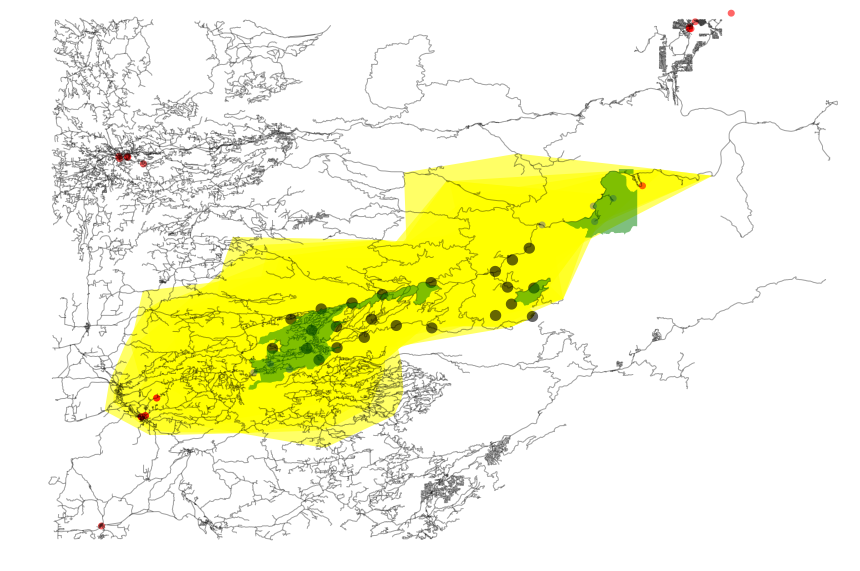

In [16]:
fig, ax = ox.plot_graph(isoc_model.graph, fig_height=10, show=False, close=False, edge_color='k', edge_alpha=0.2, node_color='none')
patch = PolygonPatch(zip_polygon, fc='green', ec='none', alpha=0.5, zorder=3)
ax.add_patch(patch)
for _, isolines in isoc_model.all_isolines:
    patch = PolygonPatch(isolines, fc='yellow', ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)
for p in close_providers_geocodes:
    if p:
        patch = PolygonPatch(p.buffer(0.005), fc='red', ec='none', alpha=0.6, zorder=-1)
        ax.add_patch(patch)
for p_id in isoc_model.covered_point_as:
    p = point_as[p_id]
    patch = PolygonPatch(p.buffer(0.005), fc='grey', ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)
for p_id in isoc_model.uncovered_point_as:
    p = point_as[p_id]
    patch = PolygonPatch(p.buffer(0.008), fc='black', ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)
plt.show()

Ok from this map, it is obvious that our zip code polygon is not accurate enough. It does not include that right hand side point As. Therefore, the resulting bounding box is smaller that it should be. and thus the isochornes are not accurate.